# QRLaXAI: Quantum Representation Learning and Explainable AI

# 1. Initialization

### 1.1 Imports
Let's import some python utilities for manipulation of images, plotting and numerical analysis.

In [1]:
import numpy as np
import warnings
import gc
import time
import os
import copy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.lines as mlines
import matplotlib.cm as cm

In [2]:
# !pip install scikit-image

In [3]:
import sklearn
import sklearn.metrics
import skimage.io 
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [4]:
# !pip install torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm5.7 uncomment if you are running this in ibm quantum lab
# !pip install torchsummary

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.utils as utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchsummary import summary
from torch.optim import lr_scheduler
from torchvision import transforms, datasets

In [6]:
# !pip install qiskit_machine_learning

In [7]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from collections import Counter
from qiskit import QuantumCircuit
from qiskit.primitives import BaseSampler
from qiskit_algorithms.optimizers import Optimizer, OptimizerResult, Minimizer
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_machine_learning.utils import  derive_num_qubits_feature_map_ansatz
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RZGate, CXGate
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.algorithms.classifiers import VQC  # Assuming neural_network_classifier is the module where VQC is defined
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal

In [8]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
algorithm_globals.random_seed = seed

In [9]:
warnings.filterwarnings('ignore') 

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1.2 Trained Model initialization
NOTE: We are going to use a pre-trained VQC model. 

In [11]:
image_shape = (16,16)
image_pixels = image_shape[0]*image_shape[1]
dataset_channels = 1
num_classes = 10
num_samples = 50
batch_size = 500

max_iter_vqc = 2
max_iter_fe = 2

fe_freezed = True

# sup-con settings
projection_units = 64
temperature_sup_con = 0.05
tolerance = 0.9

num_fm_layers = 2

fe_num_latent = 6
fe_num_trash = 2

vqc_num_qubits = 6

vqc_feature_map_type = RawFeatureVector(2 ** vqc_num_qubits) # RawFeatureVector(2 ** vqc_num_qubits) # PauliFeatureMap(vqc_num_qubits, reps=num_fm_layers, paulis=['ZZ'])

In [12]:
class QSupCon():  
    def __init__(
        self,
        num_latent: int | None = None,
        num_trash: int | None = None,
        projection_units: int | None = None,
        image_shape: tuple[int, int] | None = None,
        enc_opt_params_file_path: str | None = None,
        classifire_model_path: str | None = None,
    ) -> None:
        self.num_latent = num_latent
        self.num_trash = num_trash
        self.image_shape= image_shape
        self.projection_units = projection_units
        
        num_qbits = num_latent + num_trash

        # train qc
        self.ae_fm = self.feature_map(num_qbits)

        # auto encoder
        d_aug = self.data_augmentation_circuit(num_latent, num_trash)
        ae = self.auto_encoder_circuit(num_latent, num_trash)
        train_qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
        train_qc = train_qc.compose(self.ae_fm, range(num_latent + num_trash))
        train_qc = train_qc.compose(d_aug)
        train_qc = train_qc.compose(ae)

        train_qnn = SamplerQNN(
            circuit=train_qc,
            input_params=self.ae_fm.parameters,
            weight_params=ae.parameters,
            interpret=self.identity_interpret,
            output_shape=self.projection_units,
        )

        self.train_qnn = train_qnn

        test_qc = QuantumCircuit(num_qbits)
        test_qc = test_qc.compose(self.ae_fm)
        test_qc = test_qc.compose(self.ansatz(num_qbits))
        test_qc.barrier()

        for i in range(num_latent, num_latent+num_trash):
            test_qc.reset(i)
        self.test_qc = test_qc

        opt_result = np.load(enc_opt_params_file_path)
        self.opt_result = opt_result

        classifire = VQC.load(classifire_model_path)
        self.classifire = classifire

        self.batch = None

        self.objective_func_vals_ae = []

        self.ae_qc = ae

    def ansatz(self, num_qubits):
        return RealAmplitudes(num_qubits, reps=5)
    
    def feature_map(self, num_qubits):
        return RawFeatureVector(2 ** num_qubits)

    def predict(self, X: np.ndarray) -> np.ndarray:
        w, h = self.image_shape
        image = np.array(X.reshape(w*h))

        original_qc = self.ae_fm.assign_parameters(image)
        original_sv = Statevector(original_qc).data
        original_sv = np.reshape(np.abs(original_sv) ** 2, self.image_shape)

        param_values = np.concatenate((image, self.opt_result))
        output_qc = self.test_qc.assign_parameters(param_values)
        output_sv = Statevector(output_qc).data
        output_sv = np.reshape(np.abs(output_sv) ** 2, w*h)

        preds = self.classifire.neural_network.forward(output_sv[:2**self.num_latent], self.classifire.fit_result.x)
        
        return preds
    def predict_with_fe(self, X: np.ndarray) -> np.ndarray:

        preds = self.classifire.neural_network.forward(X, self.classifire.fit_result.x)
        
        return preds
        
    def predict_all(self, X: np.ndarray) -> np.ndarray:
        w, h = self.image_shape
        image = np.array(X.reshape(w*h))

        original_qc = self.ae_fm.assign_parameters(image)
        original_sv = Statevector(original_qc).data
        original_sv = np.reshape(np.abs(original_sv) ** 2, self.image_shape)

        param_values = np.concatenate((image, self.opt_result))
        output_qc = self.test_qc.assign_parameters(param_values)
        output_sv = Statevector(output_qc).data
        output_sv = np.reshape(np.abs(output_sv) ** 2, w*h)

        preds = self.classifire.neural_network.forward(output_sv[:2**self.num_latent], self.classifire.fit_result.x)          
        
        return output_sv[:2**self.num_latent], preds
    def train(self, batch):
        self.batch = batch
        initial_points = algorithm_globals.random.random(self.ae_qc.num_parameters)
        opt = COBYLA(maxiter=1000) # , tol=tolerance

        # make the plot nicer
        plt.rcParams["figure.figsize"] = (12, 6)

        start = time.time()
        opt_result = opt.minimize(self.cost_function, initial_points)
        elapsed = time.time() - start
        print(f"Fit in {elapsed:0.2f} seconds")
        self.opt_result = opt_result

    def cost_function(self, params_values):
        batch_images, batch_labels = self.batch

        batch_images = np.array(batch_images.reshape(len(batch_images), self.image_pixels))

        for i in range(len(batch_images)):
            sum_sq = np.sum(batch_images[i] ** 2)
            batch_images[i] = batch_images[i] / np.sqrt(sum_sq)
        
        # batch_images = (batch_images - batch_images.min()) / (batch_images.max() - batch_images.min()) * np.pi/2
        probabilities = self.train_qnn.forward(batch_images, params_values)
        
        # Normalize feature vectors
        feature_vectors_magnitude = np.linalg.norm(probabilities, axis=1, ord=2, keepdims=True)
        feature_vectors_normalized = probabilities / feature_vectors_magnitude
        # Compute logits
        logits = np.dot(feature_vectors_normalized, feature_vectors_normalized.T) / self.temperature

        loss = -np.log(np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True))
        loss = loss[np.arange(len(batch_labels)), np.array(batch_labels).squeeze()]
        cost = np.mean(loss)

        # plotting part
        clear_output(wait=True)
        self.objective_func_vals_ae.append(cost)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(self.objective_func_vals_ae)), self.objective_func_vals_ae)
        plt.show()

        return cost
    def identity_interpret(self, x):
        return x
    def ansatz(self, num_qubits):
        return RealAmplitudes(num_qubits, reps=5)
    def auto_encoder_circuit(self, num_latent, num_trash):
        qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
        cr = ClassicalRegister(1, "c")
        circuit = QuantumCircuit(qr, cr)
        circuit.compose(self.ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
        circuit.barrier()
        auxiliary_qubit = num_latent + 2 * num_trash
        # swap test
        circuit.h(auxiliary_qubit)
        for i in range(num_trash):
            circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

        circuit.h(auxiliary_qubit)
        circuit.measure(auxiliary_qubit, cr[0])
        return circuit
    def data_augmentation_circuit(self, num_latent, num_trash):
        num_qubits = num_latent + num_trash
        if num_qubits < 1:
            raise ValueError("Number of qubits must be at least 1.")

        qreg_q = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
        # creg_c = ClassicalRegister(1, 'c')
        circuit = QuantumCircuit(qreg_q)
        # circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)

        for i in range(num_qubits):
            circuit.sx(qreg_q[i])
            circuit.append(RZGate(np.pi / 2), [qreg_q[i]])
            circuit.sx(qreg_q[i])
            circuit.append(RZGate(np.pi / 2), [qreg_q[i]])

            if i < num_qubits - 1:
                circuit.append(CXGate(), [qreg_q[i], qreg_q[i + 1]])

            # circuit.measure(qreg_q[i], creg_c[0])

        return circuit

In [13]:
class_labels = [0,1] # [0,1,2,3,4,5,6,7,8,9]
dataset = 'MNIST' # F, K

In [14]:
enc_opt_params_file_path = f'./experiments/DATASET_{dataset}/fe_opt_x.npy'
classifire_model_path = f'./experiments/DATASET_{dataset}/classifire_1.model'

In [15]:
classifire_model = QSupCon(
    num_latent=fe_num_latent, 
    num_trash=fe_num_trash, 
    projection_units=projection_units,
    image_shape=image_shape, 
    enc_opt_params_file_path=enc_opt_params_file_path,
    classifire_model_path=classifire_model_path
    )

## 2. Read and pre-process image
The instance to be explained (image) is resized and pre-processed to be suitable for initialized model.

In [16]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(image_shape),
    transforms.ToTensor()
])

# Download and load the datasets
full_mn_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
full_fmn_train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
full_kmn_train_dataset = datasets.KMNIST(root='./data', train=True, transform=transform, download=True)
full_cifr_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Select the dataset based on the given 'dataset' variable
selected_dataset = (
    full_fmn_train_dataset if dataset == 'FMNIST' else
    (full_kmn_train_dataset if dataset == 'KMNIST' else
     (full_cifr_train_dataset if dataset == 'CIFAR10' else full_mn_train_dataset))
)

# Convert targets to a tensor if necessary
if not isinstance(selected_dataset.targets, torch.Tensor):
    selected_dataset.targets = torch.tensor(selected_dataset.targets)

# Filter the dataset to get num_samples samples of each specified class
selected_indices = []
for class_label in class_labels:
    indices = torch.where(selected_dataset.targets == class_label)[0][:num_samples]
    selected_indices.extend(indices.tolist())

train_dataset = torch.utils.data.Subset(selected_dataset, selected_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [17]:
# Create an iterator from the DataLoader
train_iter = iter(train_loader)

In [18]:
train_images_batch_1, train_labels_batch_1 = next(iter(train_loader))

In [19]:
Xi =  train_images_batch_1[0] # skimage.io.imread("../dataset/cropped_ear/data_levels/random sample 1/oversample/700%/test/[029]tul/image_0_8631.jpg")

In [20]:
Xi.shape

torch.Size([1, 16, 16])

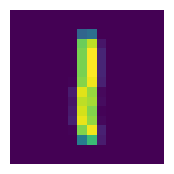

In [21]:
plt.figure(figsize=(2, 2))
plt.imshow(Xi[0])
plt.axis('off')  # to remove axes
plt.show()

## 3. Predict class of input image
The VQC model is used to predict the class of the image. The output of the classification is a vector of n proabilities of beloging to each class available in classifire model. The description of these classes is shown and it can be seen that the X is the top class for the given image.

In [22]:
preds = classifire_model.predict(Xi)

The indexes (positions) of the top 5 classes are saved in the variable `top_pred_classes`

In [23]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top n classes

array([1, 0])

## LIME explanations

### Step 1: Create perturbations of image
For the case of image explanations, perturbations will be generated by turning on and off some of the superpixels in the image.

#### Extract super-pixels from image
Superpixels are generated using the quickshift segmentation algorithm. It can be noted that for the given image, 68 superpixels were generated. The generated superpixels are shown in the image below.

Convert Grayscale to RGB 
1. 255 range
2. Transpose
3. 3 channels

In [24]:
X3i = None
if Xi.shape[0] == 1:
    X3i = Xi.expand(3, -1, -1)
    X3i = (X3i*255).numpy().astype(int)
    X3i = np.transpose(X3i, (1, 2, 0))

In [25]:
X3i.shape

(16, 16, 3)

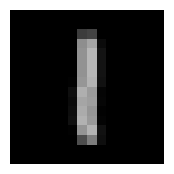

In [26]:
plt.figure(figsize=(2, 2))
plt.imshow(X3i)
plt.axis('off')  # to remove axes
plt.show()

In [27]:
superpixels = skimage.segmentation.quickshift(X3i/255, kernel_size=2, max_dist=6, ratio=0.5)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

5

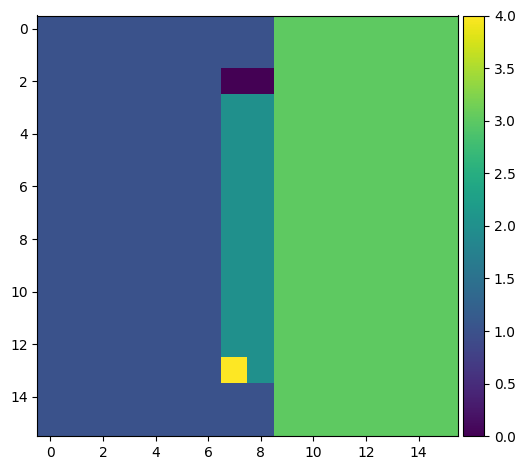

In [28]:
skimage.io.imshow(superpixels)

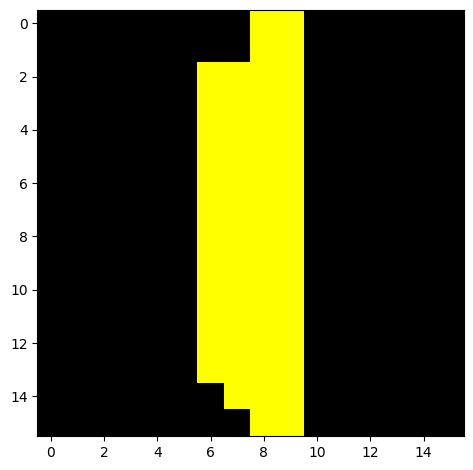

In [29]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(X3i/255, superpixels))

#### Create random perturbations

In [30]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 1, 1, 1, 0])

The following function `perturb_image` perturbs the given image (`img`) based on a perturbation vector (`perturbation`) and predefined superpixels (`segments`).

In [31]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Let's use the previous function to see what a perturbed image would look like:

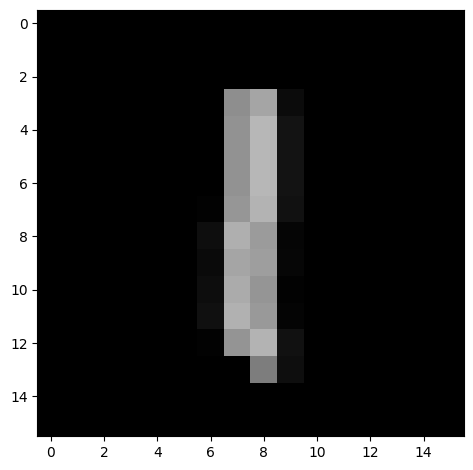

In [32]:
skimage.io.imshow(perturb_image(X3i/255, perturbations[0], superpixels))

### Step 2: Use ML classifier to predict classes of new generated images

In [33]:
predictions = []
new_perturbations = []
for pert in perturbations:
  perturbed_img = perturb_image(X3i/255, pert, superpixels)

  # classifire model accepts 1-D images
  perturbed_tensor = torch.tensor(np.transpose(np.mean(perturbed_img[np.newaxis,:,:,:][0], axis=2, keepdims=True), (2, 0, 1)))
  if not torch.all(torch.eq(perturbed_tensor, 0)):
    pred = classifire_model.predict(perturbed_tensor)
    predictions.append(pred)
    new_perturbations.append(pert)

predictions = np.array(predictions)
predictions.shape

(144, 1, 2)

### Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image

In [34]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(new_perturbations, original_image, metric='cosine').ravel()
distances.shape

(144,)

#### Use kernel function to compute weights

In [35]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(144,)

### Step 4: Use `perturbations`, `predictions` and `weights` to fit an explainable (linear) model

In [36]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=new_perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-0.01436881, -0.00597201,  0.09071688, -0.00276031,  0.00616619])

#### Compute top features (superpixels)

In [37]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([1, 3, 4, 2])

#### Show LIME explanation (image with top features)

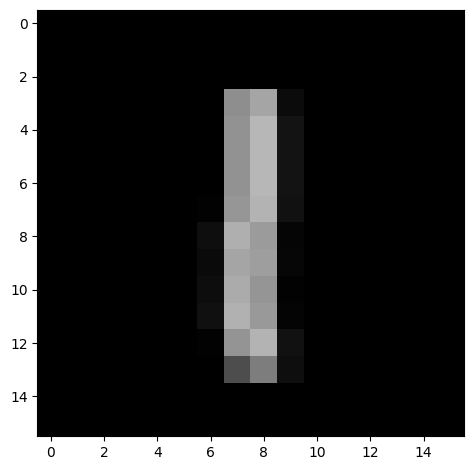

In [38]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(X3i/255, mask, superpixels))

#### Show LIME explanations for multiple images (image with top features)

In [46]:
# Define starting index, target classes, and required number of samples per class
start_index = 7
target_classes = {0, 1}
samples_per_class = 5

# Initialize dictionaries to store the samples for each class
class_counts = {0: 0, 1: 0}
selected_indices = []

# Filter `train_labels_batch_1` and `train_images_batch_1` starting from the 7th index
for i in range(start_index, len(train_labels_batch_1)):
    label = train_labels_batch_1[i].item()
    if label in target_classes and class_counts[label] < samples_per_class:
        selected_indices.append(i)
        class_counts[label] += 1

    # Stop if we've collected the required number of samples for each class
    if all(count == samples_per_class for count in class_counts.values()):
        break

# Create the filtered datasets with the selected indices
filtered_train_images = train_images_batch_1[selected_indices]
filtered_train_labels = train_labels_batch_1[selected_indices]

# Check the shapes and class distribution of the new dataset
print("Filtered train images shape:", filtered_train_images.shape)
print("Filtered train labels shape:", filtered_train_labels.shape)
print("Class distribution:", torch.bincount(filtered_train_labels))

Filtered train images shape: torch.Size([10, 1, 16, 16])
Filtered train labels shape: torch.Size([10])
Class distribution: tensor([5, 5])


In [90]:
def plot_lime_test_v2(save_path, dataset, crange1, crange2):
    range_diff = crange2 - crange1

    # Set up figure with 8 columns (Original, Superpixels, Segmentation, PT1-PT4, Top 4 Features)
    fig, axes = plt.subplots(range_diff, 16, figsize=(7, 5))  # Create subplots with fixed size for rows and columns

    for i, index in enumerate(range(crange1, crange2)):
        y_sample = filtered_train_labels[index]
        X_sample = filtered_train_images[index]

        # Expand to 3 channels if the image has 1 channel
        if X_sample.shape[0] == 1:
            X_sample_3 = X_sample.expand(3, -1, -1)
            X_sample_3 = (X_sample_3 * 255).numpy().astype(int)
            X_sample_3 = np.transpose(X_sample_3, (1, 2, 0))
        else:
            X_sample_3 = (X_sample * 255).numpy().astype(int)

        # Predict classes for the sample
        preds = classifire_model.predict(X_sample[np.newaxis, :, :, :])
        top_pred_classes = preds[0].argsort()[-5:][::-1]

        if top_pred_classes[0] != y_sample:
            pass
        
        # Generate superpixels and segmentation boundaries
        superpixels = skimage.segmentation.quickshift(X_sample_3 / 255, kernel_size=2, max_dist=6, ratio=0.5)

        # Plot the Original image
        ax = axes[i, 0]
        ax.imshow(X_sample_3 / 255)
        # if i == 0:
        #     ax.set_title(f'Original {int(y_sample)}')
        axes[i, 0].set_ylabel(f'{int(y_sample)}')
        ax.set_aspect('equal')
        ax.set_xticks([])       # Hide x-axis ticks
        ax.set_yticks([])       # Hide y-axis ticks
        ax.spines['top'].set_visible(False)    # Hide top border
        ax.spines['right'].set_visible(False)  # Hide right border
        ax.spines['bottom'].set_visible(False) # Hide bottom border
        ax.spines['left'].set_visible(False)   # Hide left border

        # Plot the Superpixels
        ax = axes[i, 1]
        ax.imshow(superpixels)
        if i == 0:
            ax.set_title('SP')
        ax.set_aspect('equal')
        ax.axis('off')

        # Plot the Segmentation with boundaries
        ax = axes[i, 2]
        ax.imshow(skimage.segmentation.mark_boundaries(X_sample_3 / 255, superpixels))
        if i == 0:
            ax.set_title('SEG')
        ax.set_aspect('equal')
        ax.axis('off')

        # Generate perturbations (PT1 to PT4)
        num_perturb = 150
        perturbations = np.random.binomial(1, 0.5, size=(num_perturb, np.unique(superpixels).shape[0]))

        # Show PT1 to PT4
        for pertubed_image in range(12):
            ax = axes[i, 3 + pertubed_image]  # PT1 starts at column index 3
            perturbed_img = perturb_image(X_sample_3 / 255, perturbations[pertubed_image], superpixels)
            ax.imshow(perturbed_img)
            if i == 0:
                ax.set_title(f'P{pertubed_image + 1}')
            ax.set_aspect('equal')
            ax.axis('off')

        # Compute top 4 features
        predictions = []
        new_perturbations = []

        for pert in perturbations:
            perturbed_img = perturb_image(X_sample_3 / 255, pert, superpixels)
            perturbed_tensor = torch.tensor(np.transpose(np.mean(perturbed_img[np.newaxis, :, :, :][0], axis=2, keepdims=True), (2, 0, 1)))
            if not torch.all(torch.eq(perturbed_tensor, 0)):
                pred = classifire_model.predict(perturbed_tensor)
                predictions.append(pred)
                new_perturbations.append(pert)

        predictions = np.array(predictions)
        original_image = np.ones(np.unique(superpixels).shape[0])[np.newaxis, :]
        distances = sklearn.metrics.pairwise_distances(new_perturbations, original_image, metric='cosine').ravel()
        kernel_width = 0.25
        weights = np.sqrt(np.exp(-(distances**2) / kernel_width**2))
        class_to_explain = top_pred_classes[0]
        simpler_model = LinearRegression()
        simpler_model.fit(X=new_perturbations, y=predictions[:, :, class_to_explain], sample_weight=weights)
        coeff = simpler_model.coef_[0]

        # Get top 4 features
        top_features = np.argsort(coeff)[-4:]
        mask = np.zeros(np.unique(superpixels).shape[0])
        mask[top_features] = True

        # Plot the Top 4 Features
        ax = axes[i, 15]  # Column index 7 for the Top 4 Features
        ax.imshow(perturb_image(X_sample_3 / 255, mask, superpixels))
        if i == 0:
            ax.set_title('T4')
        ax.set_aspect('equal')
        ax.axis('off')

    # Adjust layout for all subplots
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.3, hspace=0.01)  # Adjust space between subplots

    # Save the figure
    fig.savefig(f'{save_path}/{dataset}_lime_test_all.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    plt.close()

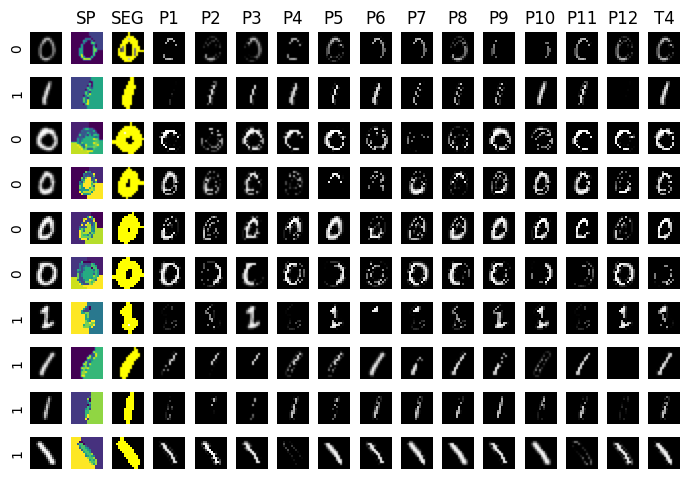

In [91]:
plot_lime_test_v2(f'./experiments/DATASET_{dataset}/', dataset, 0, 10)

# SHAP

In [82]:
# !pip install shap

In [49]:
import shap
import numpy as np
import pandas as pd

# print the JS visualization code to the notebook
shap.initjs()

In [50]:
def get_predictions(data):
    # Loop through the first 50 samples in train_images_batch_1
    rep_samples1 = []
    rep_samples2 = []
    rep_samples3 = []
    for i in range(len(data)):
        X_sample, y_sample = data[i], data[i]
        X_sample_3 = None
        
        # Check if the image is single-channel and expand to 3 channels if needed
        if X_sample.shape[0] == 1:
            X_sample_3 = np.expand_dims(np.repeat(X_sample, 3, axis=0), axis=0)  # Expanding to 3 channels
            X_sample_3 = (X_sample_3 * 255).astype(int)
            X_sample_3 = np.transpose(X_sample_3, (2, 3, 1, 0))  # Transpose to (32, 32, 3)
        
        # Make predictions using the classifier model
        fvs, preds_proba = classifire_model.predict_all(X_sample[np.newaxis, :, :, :])
        top_pred_classes = preds_proba[0].argsort()[-5:][::-1]
        rep_samples1.append(fvs)
        rep_samples2.append(preds_proba.flatten())
        rep_samples3.append(top_pred_classes[0])
        
    return rep_samples1, rep_samples2, rep_samples3

In [54]:
rep_samples50, rep_samples50_classes_proba, rep_samples50_classes = get_predictions(train_images_batch_1[:50])

In [57]:
df50 = pd.DataFrame(rep_samples50, columns=[f'f {i}' for i in range(64)])

In [71]:
def f(X):
    return classifire_model.predict_with_fe(X)

In [73]:
explainer = shap.KernelExplainer(f, df50)
shap_values = explainer.shap_values(df50, nsamples=100)

100%|█████████████████████████████████████████████| 50/50 [27:38<00:00, 33.18s/it]


In [68]:
misclassified_indices = [i for i, (pred, actual) in enumerate(zip(rep_samples50_classes, train_labels_batch_1[:20])) if pred != actual]

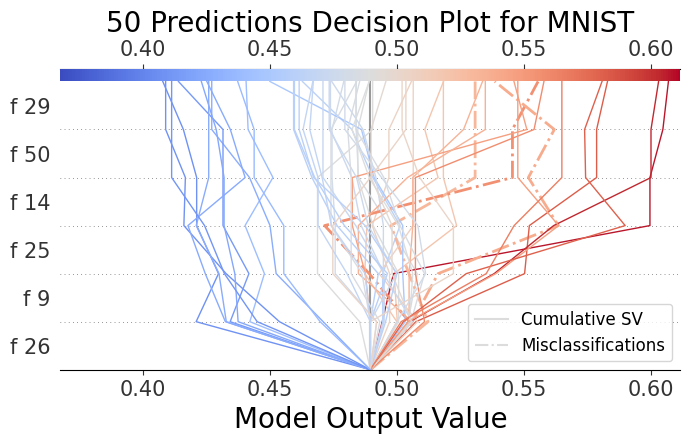

In [82]:
# Plot the decision plot for expected value 0 and save it separately
plt.figure(figsize=(10, 6))
shap.decision_plot(
    explainer.expected_value[0],           # Base value for class 0
    shap_values[..., 0],                 # SHAP values for class 0
    df50.columns,                          # Feature names
    feature_order="hclust",                # Order features hierarchically
    feature_display_range=range(5, -1, -1),  # Display top 6 features
    plot_color="coolwarm",                 # Color map
    show=False,
    highlight=misclassified_indices# Do not display immediately
)
plt.title(f"50 Predictions Decision Plot for {dataset}", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Model Output Value", fontsize=20)
legend_elements = [
    mlines.Line2D([], [], color=cm.coolwarm(0.5), linestyle='-', label='Cumulative SV'),
    mlines.Line2D([], [], color=cm.coolwarm(0.5), linestyle='-.', label='Misclassifications')
]
plt.legend(handles=legend_elements, loc="lower right", fontsize=12)
plt.show()
plt.close()  # Close the plot to free memory

In [85]:
shap_values_per_class = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

In [87]:
def class_labels_fn(row_index):
    return [
        f"Class {i} ({rep_samples50_classes_proba[row_index][i]:.5f})" 
        for i in range(2)
    ]

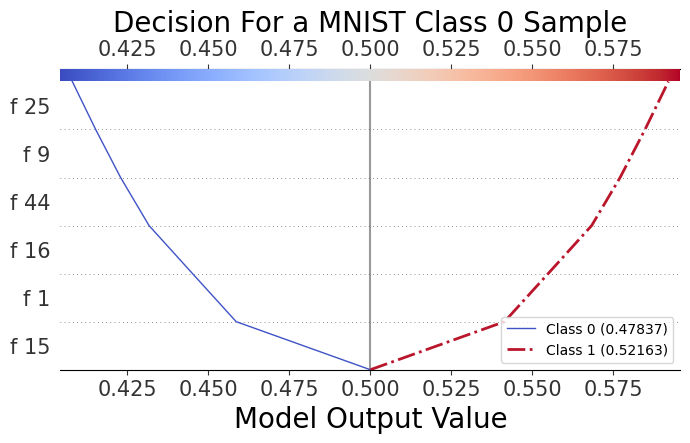

In [88]:
row_index = 7
shap.multioutput_decision_plot(
    list(explainer.expected_value),
    list(shap_values_per_class),
    row_index=row_index,
    feature_names=list(df50.columns),
    highlight=[rep_samples50_classes[row_index]],
    legend_labels=class_labels_fn(row_index),
    legend_location="lower right",
    plot_color="coolwarm",
    feature_order="hclust",
    feature_display_range=range(5, -1, -1),
    title=f'test',
    show=False
)
plt.title(f"Decision For a {dataset} Class {train_labels_batch_1[row_index]} Sample", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Model Output Value", fontsize=20)
plt.show()